# Find tracks with trackpy

Compare experimental bubble histories to bubble history correlations. Bubble detection and linking performed by Trackpy, an implementation of the Crocker-Grier algorithm [@allanTrackpy2018; @crockerMethodsDigitalVideo1996].


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colormaps  # type: ignore  # pyright 1.1.333
from matplotlib.figure import Figure
from matplotlib.pyplot import subplot_mosaic, subplots

from boilercv.correlations import (
    dimensionless_bubble_diameter_florschuetz,
    dimensionless_bubble_diameter_yuan,
    fourier,
    jakob,
    kinematic_viscosity,
    prandtl,
    reynolds,
    thermal_diffusivity,
)
from boilercv.data import apply_to_img_da
from boilercv.data.sets import get_dataset
from boilercv.docs import HIDE, init, nowarn, style_df
from boilercv.images import scale_bool
from boilercv.images.cv import Op, Transform, transform
from boilercv.models.params import PARAMS
from boilercv.stages.experiments.e230920_subcool import (
    EXP,
    GBC,
    M_TO_MM,
    THERMAL_DATA,
    Col,
    get_cat_colorbar,
    get_first_from_palette,
    get_hists,
    plot_composite_da,
    transform_cols,
)

init()

import colorcet  # noqa: F401  # Registers "cet_" prefixed colormaps in plt.colormaps
import janitor  # noqa: F401  # Registers methods on dataframes

with nowarn(capture=True):
    import trackpy as tp


tp.quiet()

figures: list[Figure] = []

In [ ]:
RELINK = False
TIME = "2023-09-20T17:14:18"

In [ ]:
PATH_TIME = TIME.replace(":", "-")
PATH = PARAMS.paths.experiments / f"{EXP}/trackpy_objects/{PATH_TIME}.h5"

video = apply_to_img_da(
    lambda img: transform(img, Transform(Op.open, 12)),
    scale_bool(get_dataset(PATH_TIME, stage="filled")["video"]),
    vectorize=True,
)

# Plotting color palettes to differentiate correlations from experimental data
WARM_PALETTE = colormaps["cet_glasbey_warm"]
COOL_PALETTE = colormaps["cet_glasbey_cool"]

# Conversion factors
PX_PER_M = 20997.3753  # (px/m)
PX_PER_MM = PX_PER_M / 1000  # (px/mm)

# Informed by the actual water temperature data
DATA = pd.read_hdf(THERMAL_DATA)
# TODO: Timezone
SUBCOOLING = DATA.subcool[TIME]

# Thresholds, back-propagated from the following analysis
GUESS_DIAMETER = 51  # (px) Guess diameter
YPX_SURFACE_THRESHOLD = 400
YPX_DEPARTURE_THRESHOLD = 420

# Values for nondimensionalization, back-propagated from the following analysis
# (s) for 1200 fps, also can be done by: FRAMETIME = np.diff(video.time.values)[1:].mean()  # s/frame
INITIAL_DY_PX = 4  # (px/frame)
INITIAL_RADIUS_OF_GYRATION_PX = 16.5  # (px)
INITIAL_RADIUS_OF_GYRATION = INITIAL_RADIUS_OF_GYRATION_PX / PX_PER_M  # (m)
INITIAL_BUBBLE_DIAMETER = 4 * INITIAL_RADIUS_OF_GYRATION  # (m)

FRAMETIME = np.diff(video.time.values).mean()

# Thresholds, back-propagated from the following analysis
MINIMUM_LIFETIME = 0.010  # (s)
MINIMUM_FRAME_LIFETIME = int(MINIMUM_LIFETIME // FRAMETIME)

# Values for nondimensionalization, back-propagated from the following analysis
# (m/s) need frametime
INITIAL_BUBBLE_VELOCITY = INITIAL_DY_PX / PX_PER_M / FRAMETIME

## Overlay first-frame detections on video composite

**Figure&NonBreakingSpace;1** shows bubble detections in the first frame of video, as well as the aggregate of all bubble tracks in the video. This aggregation does not represent individual bubble tracking, but instead acts as a heuristic for comparison of bubble traces later in the analysis.


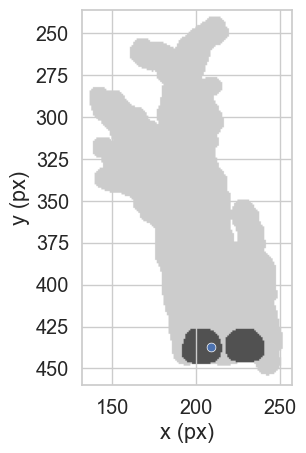

In [ ]:
figure, ax = subplots()
figures.append(figure)
first_frame = video.sel(frame=0).values
with nowarn():
    first_frame_objects = tp.locate(first_frame, diameter=GUESS_DIAMETER)
plot_composite_da(video, ax)
sns.scatterplot(
    ax=ax,
    data=first_frame_objects.rename(columns={"x": "x (px)", "y": "y (px)"}),
    x="x (px)",
    y="y (px)",
    s=40,
    legend=False,  # type: ignore  # pyright 1.1.333
)
HIDE

**Figure&NonBreakingSpace;1**: Bubbles in the first frame, their centroids, and bubble tracks  
First-frame bubbles in dark grey, bubble tracks in light grey, and centroids in blue.


## Find bubbles in each frame and link them

Detect individual bubbles in each frame, and then link detections across frames by application of the Crocker-Grier tracking algorithm, which takes into account centroid proximity and expected positions [@crockerMethodsDigitalVideo1996].

Initial and lifetime characteristics of long-lived bubbles are shown in **Table&NonBreakingSpace;1**. All bubbles departing the surface have an initial depth, $y$, close to the actual boiling surface, and a bimodal distribution in initial $x$, close to active nucleation sites. This information is used to determine surface and departure $y$ thresholds for alignment of bubble departures.


In [ ]:
if RELINK:
    # Runtime: 20 minutes
    objects: pd.DataFrame = tp.link(
        f=tp.batch(frames=video.values, diameter=GUESS_DIAMETER, characterize=False),
        search_range=30,
        memory=5,
    )
    objects.to_hdf(PATH, key="objects")
else:
    objects: pd.DataFrame = pd.read_hdf(PATH)  # type: ignore  # pyright 1.1.333

objects = (
    objects.rename(columns={"x": "xpx", "y": "ypx"})
    .assign(
        frame_lifetime=(
            lambda df: df.groupby("particle", **GBC)["frame"].transform("count")
        )
    )
    .sort_values(["frame_lifetime", "particle", "frame"], ascending=[False, True, True])
    .assign(
        bubble=(
            lambda df: df.groupby("particle", **GBC)
            .ngroup()
            .astype(pd.CategoricalDtype(ordered=True))
        ),
        dypx=lambda df: df.groupby("bubble", **GBC)[["ypx"]].diff().fillna(0),
        dxpx=lambda df: df.groupby("bubble", **GBC)[["xpx"]].diff().fillna(0),
        diameter=lambda df: 4 * df["size"] / PX_PER_M,  # radius of gyration to diam
        y=lambda df: df["ypx"] / PX_PER_M,
        x=lambda df: df["xpx"] / PX_PER_M,
        dy=lambda df: df["dypx"] / PX_PER_M / FRAMETIME,
        dx=lambda df: df["dxpx"] / PX_PER_M / FRAMETIME,
        distance=lambda df: np.linalg.norm(df[["dx", "dy"]].abs(), axis=1),
        time=lambda df: video.sel(frame=df["frame"].values)["time"],
        lifetime=lambda df: df["frame_lifetime"] * FRAMETIME,
    )
    .drop(columns=["particle"])
)

cols = [
    Col("lifetime", "Lifetime", "s"),
    Col("time", r"$t_0$", "s"),
    Col("diameter", r"$d_{b0}$", **M_TO_MM),
    Col("y", r"$y_{b0}$", **M_TO_MM),
    Col("x", r"$x_{b0}$", **M_TO_MM),
    *(hist_cols := [Col("dy", r"$v_y$"), Col("ecc", r"$\epsilon$")]),
]
with style_df(
    objects.groupby("bubble", **GBC)
    .head(1)
    .set_index("bubble")
    .assign(
        **objects.pipe(
            get_hists, groupby="bubble", cols=[col.old for col in hist_cols]
        ).set_index("bubble")
    )
    .query(f"frame_lifetime > {MINIMUM_FRAME_LIFETIME}")
    .pipe(transform_cols, cols=cols)
) as styler:
    styler.background_gradient()

,Lifetime (s),$t_0$ (s),$d_{b0}$ (mm),$y_{b0}$ (mm),$x_{b0}$ (mm),$v_y$,$\epsilon$
bubble,,,,,,,
0,0.3410,2.741,2.053,20.66,9.687,▁▁▁▁█▂▁▁▁▁,▁▁▄▅█▄▂▁▁▁
1,0.2548,0.5575,1.714,20.79,9.689,▁▁▁▁█▁▁▁▁▁,▁▃▃▁▁▅█▂▂▁
2,0.2231,1.299,2.019,20.64,9.729,▁▁▁█▂▁▁▁▁▁,▁▂▂▇▆▇█▄▁▁
3,0.1896,2.008,2.751,20.92,10.45,▁▁█▁▁▁▁▁▁▁,▁▂▃█▃▄▄▂▁▁
4,0.1806,1.625,2.130,20.67,9.737,▁▁▁▁█▁▁▁▁▁,▁▆▆▁▄█▇▂▂▁
5,0.1779,0.2996,2.540,20.98,11.06,▁▁▁▂█▇▁▁▁▁,▁▃▃▃▇█▃▂▁▁
6,0.1410,0.000,2.480,20.81,9.947,▁▁▁▁▁█▁▁▁▁,▁█▅▅▂▂▁▁▁▁
7,0.1289,2.337,2.111,20.67,9.674,▁▁█▁▁▁▁▁▁▁,▁▂▂█▅▃▂▁▂▁
8,0.1172,1.079,2.948,20.73,9.909,▁▁▁▁█▁▁▁▁▁,▁▇█▂▂▆▂▁▁▁


**Table&NonBreakingSpace;1**: Selected properties of long-lived bubbles
Bubbles are identified by a unique particle number. Their lifetime, the time of their first appearance, their initial diameter and elevation, and lifetime histograms of selected characteristics are shown.


## History of long-lived bubbles

The paths taken by long-lived bubbles are shown in **Figure&NonBreakingSpace;2**. Two active nucleation sites are responsible for all bubbles produced, and bubbles departing from each nucleation site take one of a few predominant paths during the short period of observation.


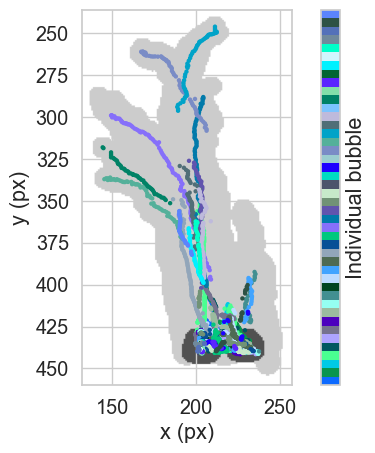

In [ ]:
figure, ax = subplots()
figures.append(figure)
plot_composite_da(video, ax)
long_lived_objects = objects.query(f"frame_lifetime > {MINIMUM_FRAME_LIFETIME}")
palette, data = get_cat_colorbar(
    ax,
    palette=COOL_PALETTE,
    data=long_lived_objects.pipe(
        transform_cols,
        [
            hue := Col("bubble", "Individual bubble"),
            x := Col("xpx", "x", "px"),
            y := Col("ypx", "y", "px"),
        ],
    ),
    col=hue.new,
)
sns.scatterplot(
    ax=ax,
    edgecolor="none",
    s=10,
    x=x.new,
    y=y.new,
    hue=hue.new,
    legend=False,  # type: ignore  # pyright 1.1.333
    palette=palette,
    data=data,
)
HIDE

**Figure&NonBreakingSpace;2**: Long-lived bubble tracks  
Bubble tracks indicated by the positions of detected centroids over time.

## Aligning bubble departures

Exclude bubbles that did not originate from the boiling surface, or that had already departed the surface at the time of recording. Consider a bubble to have departed the surface when its centroid crosses a departure threshold which is about one average bubble diameter above the boiling surface. Define the origin for time of departure for each bubble in this fashion. The resulting time history in **Figure&NonBreakingSpace;3** shows bubble depth, velocity, and diameter for the remainder of its visible lifetime.

Most bubbles rise and collapse at similar rates. Two bubbles rise slower than the rest, but seem to collapse at about the same rate as others.


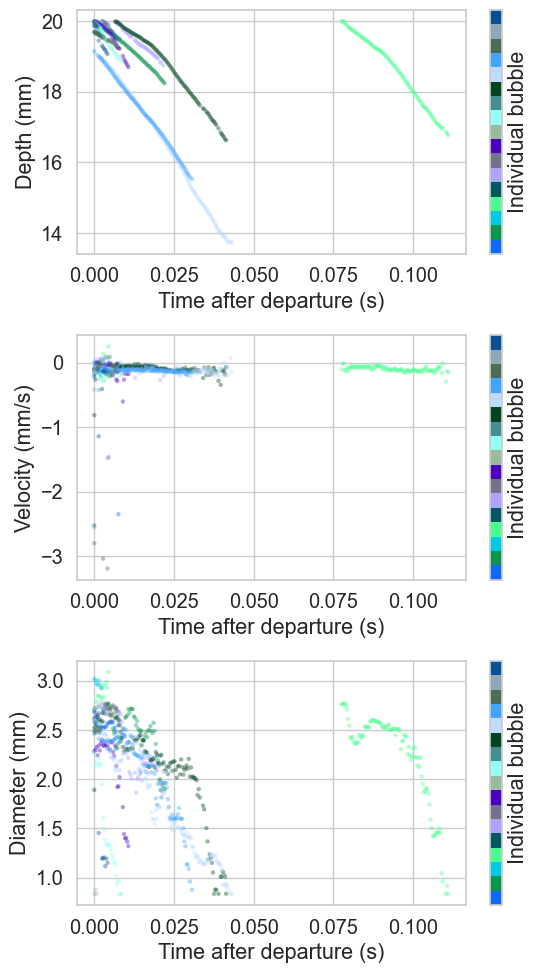

In [ ]:
departing_long_lived_objects = (
    # Find rows corresponding to stagnant or invalid bubbles
    long_lived_objects.sort_values(["bubble", "frame"])
    .groupby("bubble", **GBC)
    .apply(
        # Don't assign any other columns until invalid rows have been filtered out
        lambda df: df.assign(
            yinitpx=lambda df: df["ypx"].iat[0],
            # Initial y position is close to the surface
            began=lambda df: df["yinitpx"] > YPX_SURFACE_THRESHOLD,
            # When the bubble gets far enough away from the surface
            departed=lambda df: df["ypx"] < YPX_DEPARTURE_THRESHOLD,
        )
    )
    # Filter out invalid rows and drop the columns used to determine validity
    .pipe(lambda df: df[df["began"] & df["departed"]])
    .drop(columns=["began", "departed"])
    # Groupby again after filtering out invalid rows
    .groupby("bubble", **GBC)
    # Now columns that depend on the initial row (*.iat[0]) can be assigned
    .apply(
        lambda df: df.assign(
            frame=lambda df: df["frame"] - df["frame"].iat[0],
            time=lambda df: df["time"] - df["time"].iat[0],
            frame_lifetime=lambda df: df["frame"].iat[-1] - df["frame"].iat[0],
            lifetime=lambda df: df["frame_lifetime"] * FRAMETIME,
            yinit=lambda df: df["y"].iat[0],
            xinit=lambda df: df["x"].iat[0],
            diameterinit=lambda df: df["diameter"].iat[0],
            dyinit=lambda df: df["dy"].iat[0],
            dyinitpx=lambda df: df["dy"].iat[0],
            max_diameter=lambda df: df["diameter"].max(),
        )
    )
)

cols = [
    hue := Col("bubble", "Individual bubble"),
    x := Col("time", "Time after departure", "s"),
    y := Col("y", "Depth", **M_TO_MM),
    v := Col("dy", "Velocity", "m/s", "mm/s"),
    d := Col("diameter", "Diameter", **M_TO_MM),
]
figure, axs = subplot_mosaic([[y.new], [v.new], [d.new]])
figures.append(figure)
figure.set_size_inches(6, 10)
for plot, ax in axs.items():
    palette, data = get_cat_colorbar(
        ax,
        hue.new,
        COOL_PALETTE,
        departing_long_lived_objects.pipe(transform_cols, cols),
    )
    sns.scatterplot(
        ax=ax,
        edgecolor="none",
        s=10,
        alpha=0.4,
        x=x.new,
        y=plot,
        hue=hue.new,
        legend=False,  # type: ignore  # pyright 1.1.333
        palette=palette,
        data=data,
    )

**Figure 3**: Time history of long-lived bubbles
Bubble depth, velocity, and diameter plotted over time.


Histograms of individual bubble statistics are shown in **Figure&NonBreakingSpace;4**. Because no bubbles completely collapse, bubble lifetimes correspond to the duration of time between their departure from the boiling surface and rising past the upper limit of the camera viewpoint. The maximum bubble diameter is about 3&NonBreakingSpace;mm.

The bimodal distribution of initial $x$ positions is also evident, corresponding to two active nucleation sites. Initial bubble velocity at departure tends to be about 250&NonBreakingSpace;mm/s.


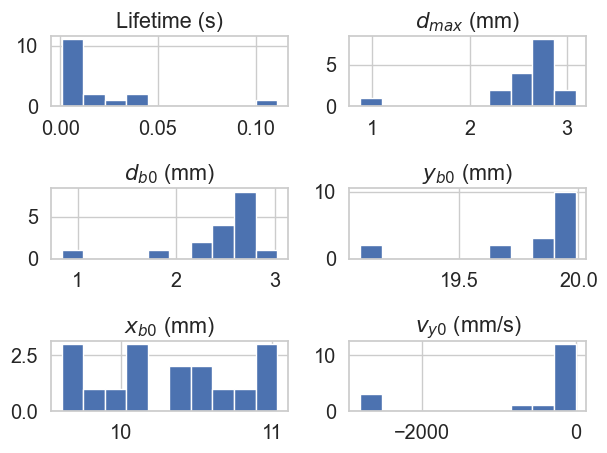

In [ ]:
figure, ax = subplots()
figures.append(figure)
(
    departing_long_lived_objects.pipe(
        transform_cols,
        [
            Col("bubble"),
            Col("lifetime", "Lifetime", "s"),
            Col("max_diameter", r"$d_{max}$", **M_TO_MM),
            Col("diameterinit", r"$d_{b0}$", **M_TO_MM),
            Col("yinit", r"$y_{b0}$", **M_TO_MM),
            Col("xinit", r"$x_{b0}$", **M_TO_MM),
            Col("dyinit", r"$v_{y0}$", old_unit="m/s", new_unit="mm/s", scale=1000),
        ],
    )
    .groupby("bubble", **GBC)
    .mean()
    .set_index("bubble")
    .hist(ax=ax)
)

HIDE

**Figure&NonBreakingSpace;4**: Histograms of individual bubble statistics  
Shows bubble lifetime, maximum diameter, and bubble properties at departure.


# Correlations

One correlation for bubble history of direct contact condensation of vapor bubbles in a subcooled liquid such considers a stagnant bubble in liquid dominated by heat transfer, which can be represented as

$$
\beta = 1 - 4{Ja}\sqrt\frac{{Fo}_0}{\pi}
$$

where $\beta$ is the dimensionless bubble diameter $D/D_0$ with $D_0$ being the initial bubble diameter, ${Ja}$ is the Jakob number $\rho_l c_{pl}\Delta T_{sub}/\rho_v h_{fg}$ , and ${Fo}_0$ is the Fourier number $\alpha t/D_{b0}^2$ [@tangReviewDirectContact2022; @florschuetzMechanicsVaporBubble1965]. This correlation was derived from analysis of the physical phenomena, and does not incorporate a fit to experimental data.

A later correlation, one which does incoprorate a fit to experimental data, is

$$
\beta = \left(1-1.8{Re}_{b0}^{1/2}Pr^{1/3}{Ja}{Fo}_0\left(1-\frac{{Ja}^{1/10}{Fo}_0}{2}\right)\right)^{2/3}
$$

where ${Re}_{b0}$ and ${Pr}$ are the bubble Reynolds and liquid Prandtl numbers, respectively [@tangReviewDirectContact2022; @yuandewenCondensationHeatTransfer2009]. Experimental bubble data is nondimensionalized by initial bubble diameter, and correlations are plotted against experimental data in **Figure&NonBreakingSpace;5**. Correlations are plotted for the average initial bubble diameter and velocity of the population of bubbles studied.

Bubble histories seem to correspond roughly with the analytical model by Florschuetz and Chao initially, with later times corresponding to the Yuan et al. model. The present bubble data shows about 0.5&NonBreakingSpace;K subcooling. Since correlations are sensitive to subcool temperature, this motivates the collection of bubble data over a wider range of subcooling.


In [ ]:
object_averages = (
    departing_long_lived_objects.set_index("bubble")
    .groupby("bubble", **GBC)
    .mean()
    .mean()
)

time = np.logspace(-6, 0) / 2  # s
latent_heat_of_vaporization = 2.23e6  # J/kg
liquid_density = 960  # kg/m^3
liquid_dynamic_viscosity = 2.88e-4  # Pa-s
liquid_isobaric_specific_heat = 4213  # J/kg-K
liquid_thermal_conductivity = 0.676  # W/m-K
vapor_density = 0.804  # kg/m^3

liquid_kinematic_viscosity = kinematic_viscosity(
    density=liquid_density, dynamic_viscosity=liquid_dynamic_viscosity
)
liquid_thermal_diffusivity = thermal_diffusivity(
    thermal_conductivity=liquid_thermal_conductivity,
    density=liquid_density,
    isobaric_specific_heat=liquid_isobaric_specific_heat,
)

bubble_initial_reynolds = reynolds(
    velocity=abs(object_averages["dyinit"]),
    characteristic_length=object_averages["diameterinit"],
    kinematic_viscosity=liquid_kinematic_viscosity,
)
liquid_prandtl = prandtl(
    dynamic_viscosity=liquid_dynamic_viscosity,
    isobaric_specific_heat=liquid_isobaric_specific_heat,
    thermal_conductivity=liquid_thermal_conductivity,
)
bubble_jakob = jakob(
    liquid_density=liquid_density,
    vapor_density=vapor_density,
    liquid_isobaric_specific_heat=liquid_isobaric_specific_heat,
    subcooling=SUBCOOLING,
    latent_heat_of_vaporization=latent_heat_of_vaporization,
)
bubble_fourier = fourier(
    liquid_thermal_diffusivity=liquid_thermal_diffusivity,
    initial_bubble_diameter=object_averages["diameterinit"],
    time=time,
)

nondimensionalized_departing_long_lived_objects = departing_long_lived_objects.assign(**{
    "Bubble Fourier number": lambda df: fourier(
        initial_bubble_diameter=df["diameterinit"],
        liquid_thermal_diffusivity=liquid_thermal_diffusivity,
        time=df["time"],
    ),
    "Dimensionless bubble diameter": (lambda df: df["diameter"] / df["diameterinit"]),
})

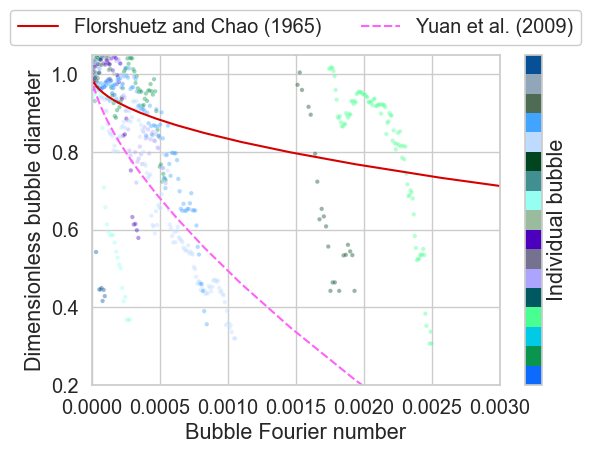

In [ ]:
figure, ax = subplots()
figures.append(figure)
ax.set_xlim(0, 0.003)
ax.set_ylim(0.2, 1.05)
sns.lineplot(
    ax=ax,
    data=(
        data := pd.DataFrame(index=bubble_fourier).assign(  # type: ignore  # pyright 1.1.333
            **{
                "Florshuetz and Chao (1965)": dimensionless_bubble_diameter_florschuetz(
                    jakob=bubble_jakob, fourier=bubble_fourier
                ),
                "Yuan et al. (2009)": dimensionless_bubble_diameter_yuan(
                    bubble_initial_reynolds=bubble_initial_reynolds,
                    liquid_prandtl=liquid_prandtl,
                    bubble_jakob=bubble_jakob,
                    bubble_fourier=bubble_fourier,
                ),
                # "Inaba et al. (2013)": dimensionless_bubble_diameter_inaba(
                #     bubble_initial_reynolds=bubble_initial_reynolds,
                #     liquid_prandtl=liquid_prandtl,
                #     bubble_jakob=bubble_jakob,
                #     bubble_fourier=bubble_fourier,
                # ),
            }
        )
    ),
    palette=get_first_from_palette(WARM_PALETTE, len(data.columns)).colors,  # type: ignore  # pyright 1.1.333
)
palette, data = get_cat_colorbar(
    ax,
    palette=COOL_PALETTE,
    data=nondimensionalized_departing_long_lived_objects.pipe(
        transform_cols,
        [
            hue := Col("bubble", "Individual bubble"),
            x := Col("Bubble Fourier number"),
            y := Col("Dimensionless bubble diameter"),
        ],
    ),
    col=hue.new,
)
sns.scatterplot(
    ax=ax,
    s=10,
    alpha=0.4,
    x=x.new,
    y=y.new,
    hue=hue.new,
    palette=palette,
    legend=False,  # type: ignore  # pyright 1.1.333
    data=data,
)
HIDE

with nowarn():
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=3)

**Figure&NonBreakingSpace;5**: Comparison of bubble histories to correlations

Two correlations are shown. The early bubble history follows that of the analytical correlation by Florshuetz and Chao (1965), while the late bubble history follows that of Yuan et al (2009).
